In [1]:
import distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import ppi
import ppi_py
import scipy.stats as stats
import pandas as pd
import ml_models as ml
import distributions as dist

import yaml
import os
import sys
import argparse
import plotting
import copy

C:\Users\huanziy\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Notebook for testing things that are/aren't working

In [2]:
def test(config):
    rho_vals = [.1]
    pop_config = config['experiment']['parameters']['gold_population']
    for rho in rho_vals:
        #pop_config['y_population']['rho'] = rho
        x_gold, y_gold = dist.sample_population(pop_config)

        print(pop_config['x_population']['size'])

        # print the gold population standard error
        print("Gold Population Standard Error: ", stats.sem(y_gold))

        # plot the x population and the y population
        fig, ax = plt.subplots(2)
        ax[0].hist(x_gold, bins=50)
        ax[0].set_title("X Population")
        ax[1].scatter(x_gold, y_gold, alpha=0.5)
        ax[1].set_title("Y Population")
        plt.show()

        ml_config = config['experiment']['model']

        train_config = copy.deepcopy(pop_config)
        train_config['x_population']['size'] = 10000

        x_train, y_train = dist.sample_population(train_config)

        model = ml.train_model(x_train, y_train, ml_config)

        y_gold_fitted = model.predict(x_gold)

        # plot the gold population and the fitted gold population

        fig, ax = plt.subplots(2)

        ax[0].scatter(x_gold, y_gold, alpha=0.5)
        ax[0].set_title("Gold Population")
        ax[1].scatter(x_gold, y_gold_fitted, alpha=0.5)
        ax[1].set_title("Fitted Gold Population")
        plt.show()
    

    return 

15
Gold Population Standard Error:  [0.23543598]


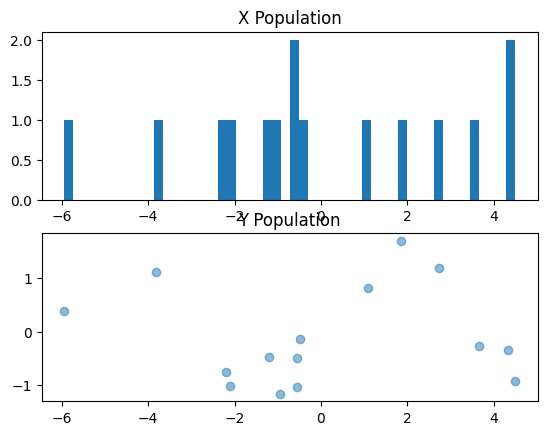

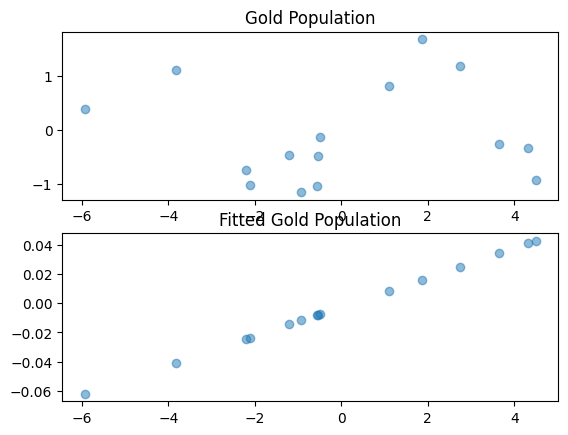

In [6]:
config = "../configs/pptest.yaml"
with open(config, 'r') as stream:
    config = yaml.safe_load(stream)
test(config)

In [8]:
config = "../configs/pptest.yaml"
with open(config, 'r') as stream:
    config = yaml.safe_load(stream)

ppi_pp_win_count = 0
ppi_win_count = 0

relative_improvement = []

for i in range(100):
    # sample

    x_train, y_train = dist.sample_population(config['experiment']['parameters']['training_population'])
    x_gold, y_gold = dist.sample_population(config['experiment']['parameters']['gold_population'])
    x_ppi, y_ppi = dist.sample_population(config['experiment']['parameters']['unlabelled_population'])

    # train
    ml_config = config['experiment']['model']
    model = ml.train_model(x_train, y_train, ml_config)

    # predict
    y_gold_fitted = model.predict(x_gold)
    y_ppi_fitted = model.predict(x_ppi)

    rectifier = np.var(y_gold_fitted - y_gold)
    f_var = np.var(y_ppi_fitted)
    print("Rectifier: ", rectifier, "Normalized Rectifier: ", rectifier/y_gold.shape[0])
    print("Fitted Variance: ", f_var, "Normalized Fitted Variance: ", f_var/y_ppi_fitted.shape[0])
    print("Proportional term:", np.sqrt(rectifier/y_gold.shape[0] + f_var/y_ppi_fitted.shape[0]))

    print("####################")

    print("Gold Population Variance: ", np.var(y_gold), "Gold Population Standard Error: ", stats.sem(y_gold))

    #print(y_ppi_fitted)

    # ppi
    ppi_pp_mean = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_ppi_fitted)
    ppi_pp_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_ppi_fitted, alpha=0.1)

    ppi_mean = ppi_py.ppi_mean_pointestimate(y_gold, y_gold_fitted, y_ppi_fitted, lhat=1)
    ppi_ci = ppi_py.ppi_mean_ci(y_gold, y_gold_fitted, y_ppi_fitted, lhat=1, alpha=0.1)

    classical_mean, classical_ci = ppi.do_classical_ci_mean(y_gold, y_gold_fitted, y_ppi_fitted, .9)

    print("PPI++: ", ppi_pp_mean, ppi_pp_ci, ppi_pp_ci[1] - ppi_pp_ci[0])
    print("PPI: ", ppi_mean, ppi_ci, ppi_ci[1] - ppi_ci[0])
    print("Classical: ", classical_mean, classical_ci, classical_ci[1] - classical_ci[0])

    print("--------------------")
    
    # print the result that performed better
    if ppi_pp_ci[1] - ppi_pp_ci[0] < ppi_ci[1] - ppi_ci[0]:
        print("PPI++ performed better")
        ppi_pp_win_count += 1
    else:
        print("PPI performed better")
        ppi_win_count += 1
    
    # append relative improvement of ppi_pp over ppi
    relative_improvement.append(((ppi_ci[1] - ppi_ci[0]) - (ppi_pp_ci[1] - ppi_pp_ci[0]))/(ppi_ci[1] - ppi_ci[0]))

print("PPI++ Win Count: ", ppi_pp_win_count, "PPI Win Count: ", ppi_win_count)
print("Average Relative Improvement: ", np.mean(relative_improvement))

Rectifier:  1590.5664356277875 Normalized Rectifier:  106.03776237518584
Fitted Variance:  5529.963595019588 Normalized Fitted Variance:  110.59927190039176
Proportional term: 14.71859484718489
####################
Gold Population Variance:  1703.6413559762143 Gold Population Standard Error:  [11.03125869]
PPI++:  [-1.89482178] (array([-12.01142303]), array([8.22177947])) [20.2332025]
PPI:  [-16.72065095] (array([-40.93058506]), array([7.48928317])) [48.41986824]
Classical:  7.413028531193574 (-12.016439209723352, 26.842496272110502) 38.85893548183385
--------------------
PPI++ performed better
Rectifier:  1616.118409171437 Normalized Rectifier:  107.74122727809579
Fitted Variance:  5083.088067645987 Normalized Fitted Variance:  101.66176135291975
Proportional term: 14.470763235953228
####################
Gold Population Variance:  3348.7314192098097 Gold Population Standard Error:  [15.46593358]
PPI++:  [-12.24720208] (array([-28.19224791]), array([3.69784375])) [31.89009166]
PPI:  [0

In [84]:
stats.sem(np.array([1, 2, 3, 4]))

0.6454972243679028

In [2]:
gamma_1 = np.random.gamma(2, 2, 100000).flatten()
gamma_2 = np.random.gamma(5, 6, 100000).flatten()

wass = stats.wasserstein_distance(gamma_1, gamma_2)
print(wass)

26.022687908066292
